In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.transforms import ScaledTranslation
%matplotlib inline

In [2]:
# Load results
df_fva = pd.read_excel('./results/FVA_RBA_bounds_processed_for_reversibility.xlsx')
df_fva.index = df_fva.rxn.to_list()

# Remove pseudoreaction
df_fva = df_fva[df_fva.subsystem != 'Pseudoreaction']
df_fva = df_fva[df_fva.subsystem != 'Transport']
df_fva = df_fva[df_fva.subsystem != 'Exchange']

# Handle reversible rxns with non-zero reverse flux
#df_fva = df_fva[(df_fva.fva_max > 0) | (df_fva.fva_min < 0)]
#print('Flux-carrying metabolic rxns:', df_fva.shape[0])

# Load pathway assignment
ss_dict = dict()
df_path = pd.read_excel('./input/pathway_regroup.xlsx')

for i in df_path.index:
    p,pgroup = df_path.loc[i, ['Pathway', 'Pathway group']]
    if pd.isnull(p) == False:
        ss_dict[p] = pgroup
ss_dict['Transport'] = 'Transport'
ss_dict['Exchange'] = 'Exchange'
ss_dict['Pseudoreaction'] = 'Pseudoreaction'
        
# Update pathway assignment to result dataframe 
for i in df_fva.index:
    df_fva.loc[i, 'subsystem_group'] = ss_dict[df_fva.subsystem[i]]

In [3]:
ub_ratio = pd.core.series.Series(dtype='float64')
for rxn in df_fva.index:
    rmax,fmax,fmin = df_fva.loc[rxn, ['rba_max', 'fva_max', 'fva_min']]
    if fmax - fmin < 1e-7:
        ub_ratio[rxn] = 1
    else:
        ub_ratio[rxn] = rmax / fmax

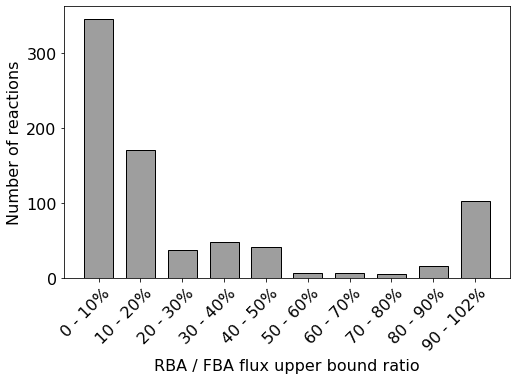

In [4]:
# Slight shift down so that ratio = 1 entries are not assigned to >= 1 bin
for rxn in ub_ratio[ub_ratio == 1.0].index:
    ub_ratio[rxn] = 0.9999
    
# Assign the six glycolysis rxns whose bound ratio is ~102% to be in the last bin
# Bin is labeled accordingly to 90-102%
for rxn in ub_ratio[(ub_ratio > 1) & (ub_ratio < 1.02)].index:
    ub_ratio[rxn] = 0.9999

fig,ax = plt.subplots(figsize=(8,5))
rwidth = 0.7

gap = 0.1
bins = [round(i*gap,1) for i in range(0,11)]
ax.hist(ub_ratio, bins=bins, rwidth=rwidth,
        color='#9e9e9e', edgecolor='k');

yticks = [0, 100, 200, 300]
ax.set_yticks(yticks);
ax.set_yticklabels(yticks, fontsize=16);
ax.set_ylabel('Number of reactions', fontsize=16);

xticks = [(i+0.5)*0.1 for i in range(0, len(bins)-1)]
ax.set_xticks(xticks);

xticklabels = [str(i*10) + ' - ' + str((i+1)*10) + '%' for i in range(0, len(bins)-2)]
xticklabels += ['90 - 102%']
ax.set_xticklabels(xticklabels, fontsize=16);
offset = ScaledTranslation(0.2, 0, fig.dpi_scale_trans)
for label_obj in ax.get_xticklabels():
    label_obj.set_rotation(45)
    label_obj.set_transform(label_obj.get_transform() + offset)
    label_obj.set_horizontalalignment('right')
    
ax.set_xlabel('RBA / FBA flux upper bound ratio', fontsize=16);
#plt.savefig('../../scRBA_figures/components/Fig6_RBAoverFBA_fluxUB_ratio_histogram.png', transparent=True, bbox_inches='tight')